In [1]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.linear_model import LogisticRegression

import time

import numpy as np

In [2]:
def plot_confusion_matrix(y_true, y_pred, display_labels, title, cmap='viridis'):
    # Compute normalized confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Create and plot the confusion matrix display
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    cm_display.plot(ax=ax, cmap=cmap, colorbar=False)
    
    # Set plot title and labels
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    # Rotate y-tick labels for better readability
    plt.setp(ax.get_yticklabels(), rotation=45)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


In [3]:
# Download latest version
path = kagglehub.dataset_download("sooyoungher/smoking-drinking-dataset")
print("Path to dataset files:", path)

file_name = "smoking_driking_dataset_Ver01.csv"
file_path = f"{path}/{file_name}"
df = pd.read_csv(file_path)

Path to dataset files: C:\Users\umbeg\.cache\kagglehub\datasets\sooyoungher\smoking-drinking-dataset\versions\2


In [4]:
df.columns

Index(['sex', 'age', 'height', 'weight', 'waistline', 'sight_left',
       'sight_right', 'hear_left', 'hear_right', 'SBP', 'DBP', 'BLDS',
       'tot_chole', 'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
       'urine_protein', 'serum_creatinine', 'SGOT_AST', 'SGOT_ALT',
       'gamma_GTP', 'SMK_stat_type_cd', 'DRK_YN'],
      dtype='object')

# Feature Engineering

## Anthropometric Features

In [5]:
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2                     # Use to assess overall obesity.
df['wth_ratio'] = df['waistline'] / df['height']                         # A good indicator of central (abdominal) obesity and cardiovascular risk.
df['wtw_ratio'] = df['waistline'] / df['weight']                         # May provide additional insights into fat distribution.
df['obesity_flag'] = (df['BMI'] >= 30).astype(int)

## Cardiovascular Features

In [6]:
def bp_category(row):
    if row['SBP'] < 120 and row['DBP'] < 80:
        return 'Normal'
    elif row['SBP'] < 140 and row['DBP'] < 90:
        return 'Prehypertensive'
    else:
        return 'Hypertensive'

df['pulse_pressure'] = df['SBP'] - df['DBP']                             # High pulse pressure is linked to arterial stiffness and cardiovascular risk.
df['MAP'] = (2 * df['DBP'] + df['SBP']) / 3
df['bp_category'] = df.apply(bp_category, axis=1)


## Lipid Profile & Metabolic Ratios


In [7]:
df['TC_HDL_ratio'] = df['tot_chole'] / df['HDL_chole']                   # Widely used to assess cardiovascular risk.
df['LDL_HDL_ratio'] = df['LDL_chole'] / df['HDL_chole']                              
df['non_HDL_chole'] = df['tot_chole'] - df['HDL_chole']                  # Represents the atherogenic (bad) cholesterol particles.
df['triglyceride_hdl_ratio'] = df['triglyceride'] / df['HDL_chole']      

df["AIP"] = np.log10(df['triglyceride'] / df['HDL_chole'])               # Atherogenic index of plasma.
df['TyG'] = np.log(df['triglyceride'] * df['BLDS'] / 2)                   

## Liver and Kidney Function Features

In [8]:
def calc_eGFR(row):
    # Using the CKD-EPI formula from 2009
    # https://doi.org/10.7326/0003-4819-150-9-200905050-00006

    SCr = row['serum_creatinine']
    age = row['age']
    is_female = row['sex'] == 'Female'
    
    k = 0.7 if is_female else 0.9
    a = -0.329 if is_female else -0.411

    eGFR = 141 * min(SCr / k, 1) ** a * max(SCr / k, 1) ** (-1.209) * 0.993 ** age
    eGFR *= 1.018 if is_female else 1

    return eGFR

df['AST_ALT_ratio'] = df['SGOT_AST'] / df['SGOT_ALT']                    # Can help in differentiating types of liver disease (for example, a high ratio might indicate alcoholic liver disease).
df['liver_enzyme_interaction'] = df['gamma_GTP'] * df['SGOT_AST']
df['liver_enzyme_avg'] = (df['SGOT_AST'] + df['SGOT_ALT'] + df['gamma_GTP']) / 3
df['eGFR'] = df.apply(calc_eGFR, axis=1)

# Model Performance

In [9]:
label_encoders = {}

for column in df.columns:
    if df[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])


In [10]:
# Calculate Z-scores
z_scores = np.abs(stats.zscore(df.select_dtypes(include=['number'])))

# Set a threshold for Z-scores
threshold = 5

# Filter out rows with Z-scores above the threshold
df_no_outliers = df[(z_scores < threshold).all(axis=1)]

# Print the number of rows removed
print(f"Number of rows removed: {len(df) - len(df_no_outliers)}")

df = df_no_outliers

Number of rows removed: 79322


In [11]:
df.head()

,sex,age,height,weight,waistline,sight_left,sight_right,hear_left,hear_right,SBP,...,TC_HDL_ratio,LDL_HDL_ratio,non_HDL_chole,triglyceride_hdl_ratio,AIP,TyG,AST_ALT_ratio,liver_enzyme_interaction,liver_enzyme_avg,eGFR
0,1,35,170,75,90.0,1.0,1.0,1.0,1.0,120.0,...,4.020833,2.625000,145.0,1.916667,0.282547,8.423761,0.600000,840.0,32.000000,97.078265
1,1,30,180,80,89.0,0.9,1.2,1.0,1.0,130.0,...,4.145455,2.690909,173.0,2.200000,0.342423,8.766082,0.555556,540.0,27.666667,114.208011
2,1,40,165,75,91.0,1.2,1.5,1.0,1.0,120.0,...,3.317073,1.804878,95.0,2.536585,0.404249,8.536211,1.468750,3196.0,49.000000,106.460635
3,1,50,175,80,91.0,1.5,1.2,1.0,1.0,145.0,...,2.644737,1.368421,125.0,1.394737,0.144492,8.524169,0.852941,522.0,27.000000,77.860462
4,1,50,165,60,80.0,1.0,1.2,1.0,1.0,138.0,...,3.262295,1.918033,138.0,1.704918,0.231704,8.566364,1.583333,475.0,18.666667,104.161020


In [12]:
X = df.drop(['DRK_YN', 'SMK_stat_type_cd'], axis=1).copy()
y_smoke = df['SMK_stat_type_cd'].copy()

## Independent targets

In [13]:
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(X, y_smoke, test_size=0.2, random_state=42, stratify=y_smoke)

In [ ]:
X_train_smoke_first_step = X_train_smoke.copy()
y_train_smoke_first_step = (y_train_smoke != 1).astype(int)

y_test_smoke_first_step = (y_test_smoke != 1).astype(int)

X_train_smoke_second_step = X_train_smoke.copy()
y_train_smoke_second_step = y_train_smoke.copy()

In [15]:
# scale the data
scaler = StandardScaler()

X_train_smoke_first_step_scaled = scaler.fit_transform(X_train_smoke_first_step)
X_test_smoke_scaled = scaler.transform(X_test_smoke)
X_train_smoke_second_step_scaled = scaler.fit_transform(X_train_smoke_second_step)

In [16]:
first_step = LinearSVC(class_weight='balanced', random_state=42)

In [17]:
first_step.fit(X_train_smoke_first_step_scaled, y_train_smoke_first_step)

LinearSVC(class_weight='balanced', random_state=42)

In [18]:
second_step = LinearSVC(class_weight='balanced', random_state=42)
# second_step = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)


In [19]:
second_step.fit(X_train_smoke_second_step_scaled, y_train_smoke_second_step)

LinearSVC(class_weight='balanced', random_state=42)

In [ ]:
first_step_preds = first_step.predict(X_test_smoke_scaled)

print(classification_report(y_, first_step_preds))

plot_confusion_matrix(y_train_smoke_first_step, first_step_preds, first_step.classes_, 'First Step Confusion Matrix')

ValueError: Found input variables with inconsistent numbers of samples: [729619, 182405]

In [21]:
non_smokers = X_test_smoke[first_step_preds == 0]
possible_smokers = X_test_smoke[first_step_preds == 1]

possible_smokers_scaled = scaler.transform(possible_smokers)

In [22]:
second_step_preds = second_step.predict(possible_smokers_scaled)
print(np.unique(second_step_preds, return_counts=True))

(array([1., 2., 3.]), array([   31, 42253, 53500], dtype=int64))


              precision    recall  f1-score   support

         1.0       0.94      0.73      0.82    111704
         2.0       0.41      0.55      0.47     31616
         3.0       0.48      0.65      0.55     39085

    accuracy                           0.68    182405
   macro avg       0.61      0.64      0.61    182405
weighted avg       0.75      0.68      0.70    182405



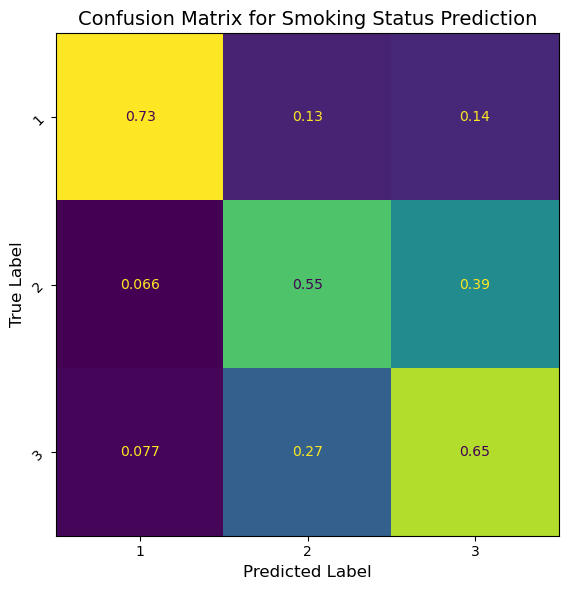

In [23]:
# Combine the predictions
final_preds = first_step_preds.copy()

final_preds[first_step_preds == 1] = second_step_preds
final_preds[final_preds == 0] = 1

report = classification_report(y_test_smoke, final_preds)
print(report)

plot_confusion_matrix(y_test_smoke, final_preds, [1, 2, 3], 'Confusion Matrix for Smoking Status Prediction')